In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc
import numpy as np
import pandas as pd
from DB import DB
import util
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
games, stacked, teams = util.get_data(2013)

In [4]:
# bteams = pd.read_sql("SELECT * FROM teams WHERE conf='B10'", DB.conn)
# b10_teams = set(bteams.ncaaid.values)
# stacked = util.get_box_games(2015)
# stacked = stacked.loc[(stacked.hteam_id.isin(b10_teams)) & (stacked.ateam_id.isin(b10_teams))]
# stacked = stacked.merge(bteams[['ncaaid', 'ncaa']], left_on="team", right_on="ncaa")
# stacked = stacked[['game_id', 'dt', 'ncaa', 'ncaaid', 'hteam_id', 'ateam_id', 'pts', 'poss']]

# stacked.shape
games.shape, stacked.shape

((5267, 13), (10534, 10))

In [5]:
# def get_teams(games):
#     hteams = games[['hteam_id']]
#     ateams = games[['ateam_id']]
#     hteams = hteams.rename(columns={'hteam_id': 'team_id'})
#     ateams = ateams.rename(columns={'ateam_id': 'team_id'})
#     teams = pd.concat([hteams, ateams], axis=0)
#     teams.drop_duplicates(inplace=True)
#     teams = teams.reset_index()
#     teams['iteam'] = teams.index.values
#     teams.drop('index', 1, inplace=True)
#     return teams
# teams = get_teams(stacked)
# teams = teams.merge(bteams[['ncaaid', 'ncaa']], left_on='team_id', right_on='ncaaid')

In [6]:
# teams.head()
# stacked = stacked.merge(teams[['team_id', 'iteam']], left_on="ncaaid", right_on="team_id")
# stacked.head()

In [7]:
pace_initial = stacked.groupby('iteam').mean()['poss'].values
teams['pace_initial'] = pace_initial

In [8]:
num_teams = teams.shape[0]
home_team_idx = games.i_hteam.values
away_team_idx = games.i_ateam.values
observed_pace = games.poss.values
tau = pymc.Uniform('tau', (1. / 20**2), (1. / 3**2))  # equivalent to stddev between 1 and inf
pace_prior = pymc.Normal("pace_prior", mu=0, tau=tau, size=num_teams, value=pace_initial)
pace_intercept = pymc.Normal('intercept', 4, 1 / (1)**2, value=4)

@pymc.deterministic
def pace_rtg(pace=pace_prior):
    p = pace.copy()
    p = p - np.mean(pace)
    return p
        
@pymc.deterministic
def mu_pace(home_team=home_team_idx,
               away_team=away_team_idx,
               paces=pace_rtg,
               pace_intercept=pace_intercept):
    return pace_intercept + paces[home_team] + paces[away_team]

tau_poss = pymc.Uniform('tau_poss', (1 / 20)**0.5,(1 / 1)**0.5)
poss = pymc.Normal('poss', mu=mu_pace, tau=tau_poss, value=observed_pace, observed=True)
# poss = pymc.Poisson('poss', mu=mu_pace, value=observed_pace, observed=True)
poss_pred = pymc.Normal('poss_pred', mu=mu_pace, tau=tau_poss)


In [9]:
model = pymc.Model([mu_pace, pace_prior, tau, pace_rtg, poss, pace_intercept, tau_poss, poss_pred])
mcmc = pymc.MCMC(model)
mcmc.sample(10000, 3000)

 [-----------------100%-----------------] 10000 of 10000 complete in 10.4 sec

In [10]:
pace_intercept.stats()['mean'], np.sqrt(1/tau.stats()['mean'])

(66.162621511883572, 19.994157189696821)

Plotting intercept


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


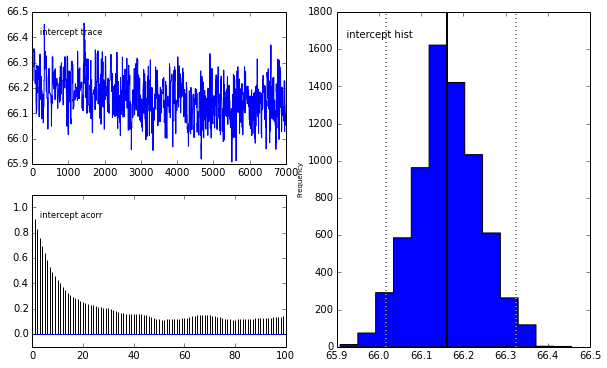

In [11]:
pymc.Matplot.plot(pace_intercept)

(array([ 0.00131245,  0.01330183,  0.04643224,  0.06420348,  0.04029567,
         0.01585578,  0.00393734,  0.00102867,  0.00031924,  0.00014189]),
 array([  47.3625,   52.715 ,   58.0675,   63.42  ,   68.7725,   74.125 ,
          79.4775,   84.83  ,   90.1825,   95.535 ,  100.8875]),
 <a list of 10 Patch objects>)

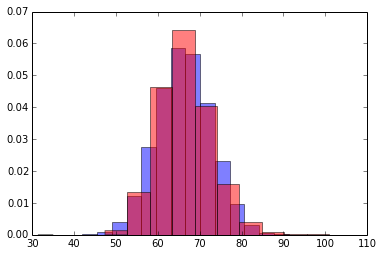

In [12]:
plt.hist(poss_pred.trace().ravel(), normed=True, alpha=0.5, bins=20)
# plt.hist(observed_pace)
plt.hist(observed_pace[~pd.isnull(observed_pace)], color='r', normed=True, alpha=0.5)

In [13]:
bteams = pd.read_sql("SELECT * FROM teams WHERE conf='B10'", DB.conn)
b10_teams = set(bteams.ncaaid.values)

In [18]:
pace_intercept.stats()
teams['pace'] = pace_rtg.stats()['mean']
teams['pace2'] = teams.pace + pace_intercept.stats()['mean']
teams['pace_initial_rank'] = teams.pace_initial.rank(ascending=False) + 4
teams['pace_rank'] = teams.pace.rank(ascending=False) + 4
teams[teams.team_id.isin(b10_teams)].sort('pace', ascending=False)

teams.sort('pace', ascending=False).head(50)

,iteam,team_id,ncaa,pace_initial,pace,pace_initial_rank,pace_rank,pace2
176,176,1004,Central Ark.,74.900000,8.300111,5,5,74.462732
334,334,474,New Orleans,73.870455,6.863025,6,6,73.025646
222,222,310,Iona,72.331618,6.331750,9,7,72.494372
43,43,176,DePaul,72.454688,6.263261,8,8,72.425883
183,183,670,Texas St.,71.715152,6.119526,18,9,72.282148
125,125,508,Northwestern St.,73.402679,6.043570,7,10,72.206192
342,342,2,Abilene Christian,71.900000,5.909662,12,11,72.072284
156,156,28600,Lipscomb,71.869828,5.718211,13,12,71.880833
122,122,31,Arkansas,70.791667,5.644337,30,13,71.806959
260,260,288,Houston,71.372656,5.515113,21,14,71.677735


In [25]:
games.head()

,game_id,dt,hteam,team_id_x,ateam,team_id_y,hpts,hposs,apts,aposs,i_hteam,i_ateam,poss
0,1999211,2013-04-02,Iowa,312,Maryland,392,71,63.400,60,64.600,1,83,64.0000
1,1948633,2013-03-22,Iowa,312,Stony Brook,683,75,62.975,63,63.075,1,234,63.0250
2,1942259,2013-03-20,Iowa,312,Indiana St.,305,68,65.350,52,65.225,1,54,65.2875
3,1871394,2013-03-09,Iowa,312,Nebraska,463,74,56.125,60,56.225,1,6,56.1750
4,1835252,2013-03-05,Iowa,312,Illinois,301,63,67.500,55,68.075,1,34,67.7875


In [118]:
games['pred'] = np.mean(poss_pred.trace(), axis=0)
trace = poss_pred.trace()
trace.shape

(7000, 5267)

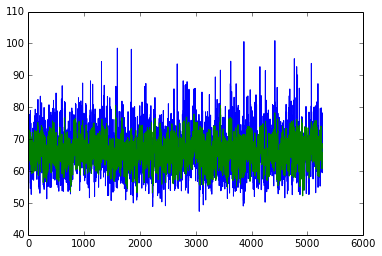

In [30]:
plt.plot(range(games.shape[0]), games.poss)
plt.plot(range(games.shape[0]), games.pred)

In [31]:
from sklearn.metrics import r2_score

In [32]:
r2_score(games.poss, games.pred)

0.38777394311599989

(array([   16.,    93.,   413.,  1195.,  1830.,  1760.,  1178.,   406.,
           94.,    15.]),
 array([ 65.7970665 ,  65.86804546,  65.93902442,  66.01000337,
         66.08098233,  66.15196129,  66.22294025,  66.29391921,
         66.36489817,  66.43587713,  66.50685609]),
 <a list of 10 Patch objects>)

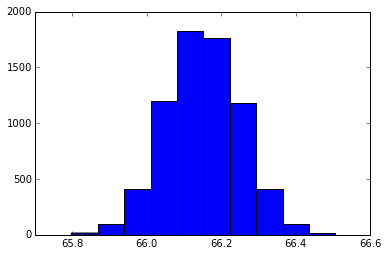

In [36]:
season_average = np.mean(poss_pred.trace(), axis=1)
plt.hist(season_average)

(array([   7.,   30.,  125.,  250.,  515.,  794.,  948.,  862.,  685.,
         451.,  297.,  150.,   82.,   29.,   23.,    6.,    4.,    5.,
           1.,    3.]),
 array([  47.3625 ,   50.03875,   52.715  ,   55.39125,   58.0675 ,
          60.74375,   63.42   ,   66.09625,   68.7725 ,   71.44875,
          74.125  ,   76.80125,   79.4775 ,   82.15375,   84.83   ,
          87.50625,   90.1825 ,   92.85875,   95.535  ,   98.21125,
         100.8875 ]),
 <a list of 20 Patch objects>)

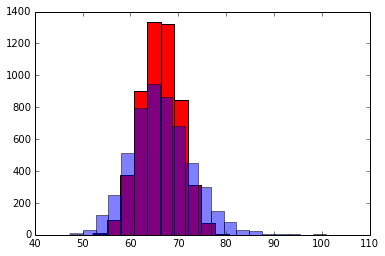

In [43]:
game_dist = np.mean(poss_pred.trace(), axis=0)
plt.hist(game_dist, alpha=1, color='r')
plt.hist(observed_pace, alpha=0.5, bins=20)

In [100]:
pace_rtg.stats().keys()

['95% HPD interval',
 'n',
 'quantiles',
 'standard deviation',
 'mc error',
 'mean']

In [101]:
teams['pace_var'] = pace_rtg.stats()['standard deviation']

['Baylor' 'Iowa' 'Virginia' 'Michigan St.' 'Northwestern' 'Indiana'
 'Nebraska' 'Penn St.' 'Wisconsin' 'Minnesota']



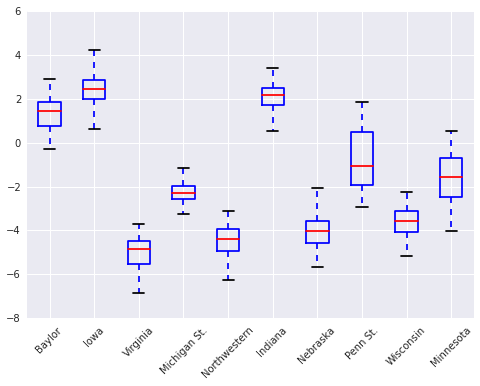

In [117]:
fig, ax = plt.subplots(1, 1)
trace = pace_rtg.trace()
df = pd.DataFrame(trace)
df.head()
data_to_plot = df.iloc[:, :10].values
tms = teams.ncaa[:10].values
print tms
ax.boxplot(data_to_plot)
ax.set_xticklabels(tms, rotation=45)
print

In [59]:
data = sns.load_dataset("exercise")

In [64]:
data.head()

,Unnamed: 0,id,diet,pulse,time,kind
0,0,1,low fat,85,1 min,rest
1,1,1,low fat,85,15 min,rest
2,2,1,low fat,88,30 min,rest
3,3,2,low fat,90,1 min,rest
4,4,2,low fat,92,15 min,rest


AttributeError: 'numpy.ndarray' object has no attribute 'get'

In [94]:
df = pd.DataFrame(t.ravel(), columns=['data'])
df['factor'] = (np.arange(345 * 7000) % 347)

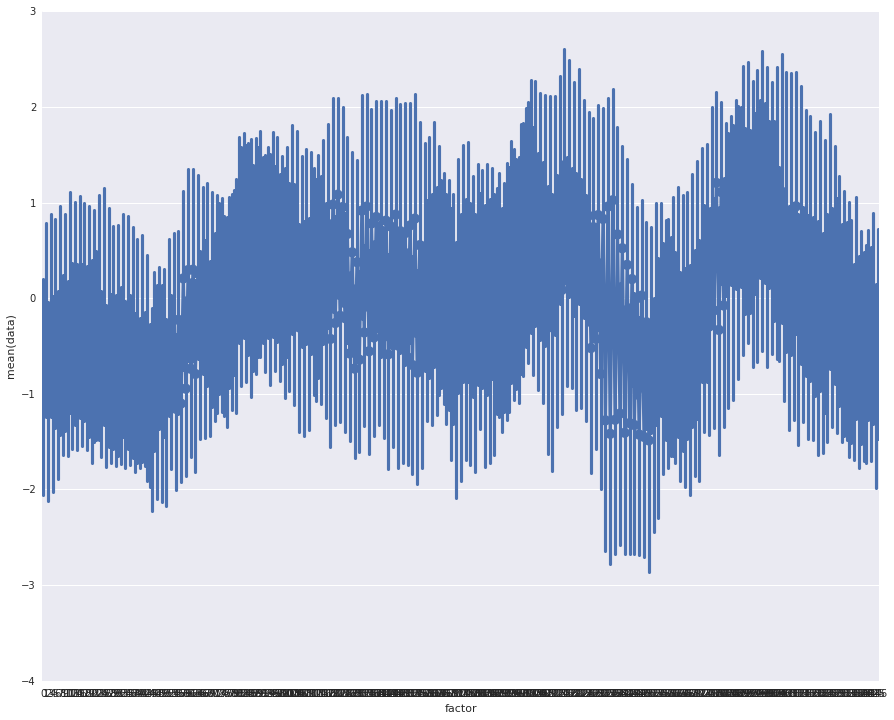

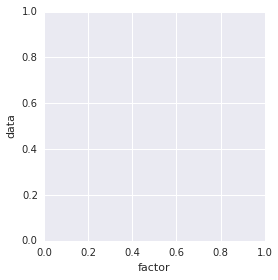

In [96]:
fig, ax = plt.subplots(1,1, figsize=(15, 12))
g = sns.factorplot(x="factor", y="data", data=df.iloc[:8000, :], ax=ax)

In [81]:
df.iloc[10, :]

data      -0.276807
factor    10.000000
Name: 10, dtype: float64

In [88]:
np.array([[i]*7000 for i in xrange(345)]).ravel().shape

(2415000,)

In [90]:
t.shape

(7000, 345)